In [1]:
import functions
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from scipy.signal import  filtfilt, butter, iirnotch, find_peaks, sosfilt
from sklearn.decomposition import FastICA as skFastICA

In [2]:
fs=1000
span = 3000
offset = 100*fs 

In [3]:
dd = functions.array_from_TDMSgroup("patients/P048/P048_S01_D2024-06-06_G26.tdms", "R001")
bp_data = functions.bandpass_filter(dd, low=0.5, high= 80)

In [4]:
# normally, they were using deflation algorithm but parallel is much much faster, and produce similar results
sources, ica = functions.FASTICA(bp_data, n_comp=30, algo='parallel')

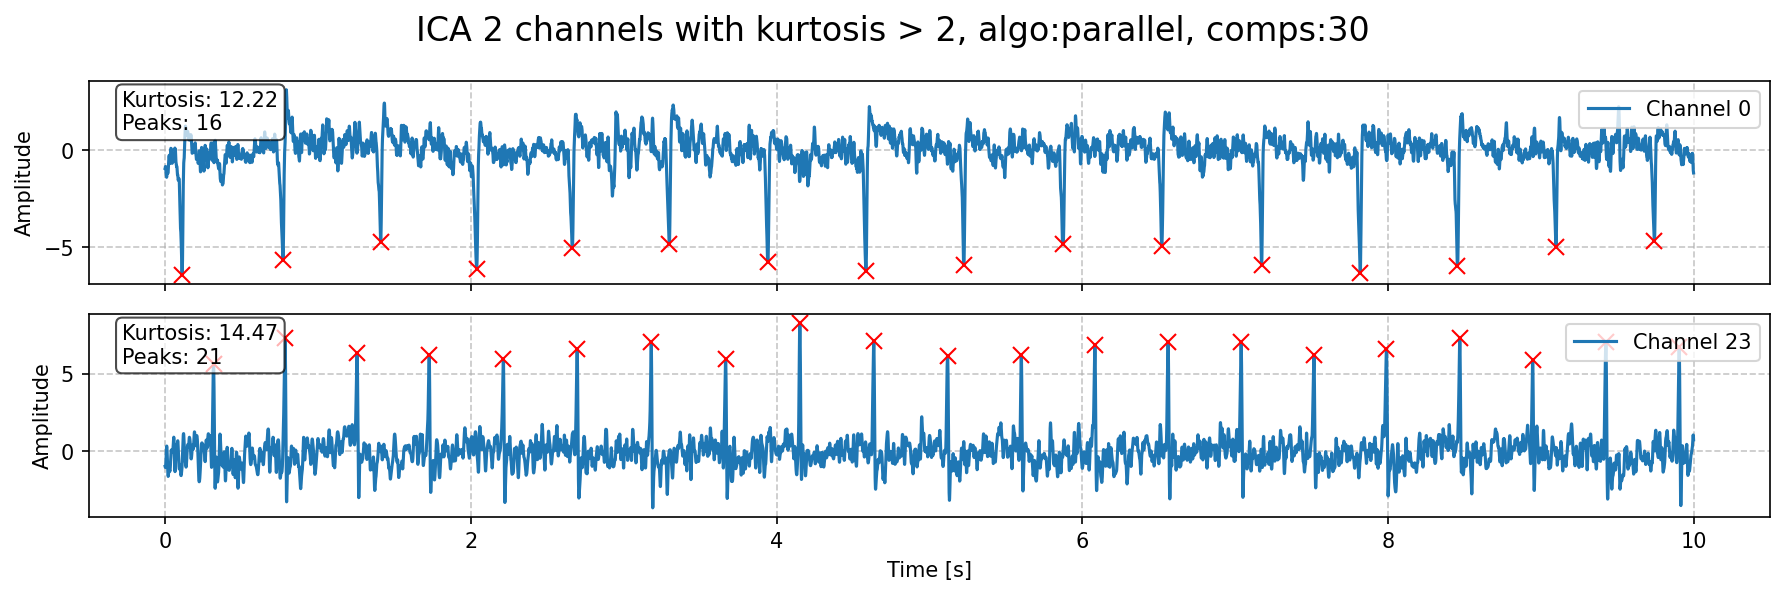

In [97]:
compF, maternals = functions.plotICA(sources, ica, offset= 10*fs, span=10*fs, kurt_threshold=2, mse_th=1)

### Let's only eleminate fetal signal from the mixing matrix, and up and down sample the remaining channels, to consturct measurement space again

In [98]:
print(compF)
ica.mixing_[:, compF] = 0
maternal_sources = deepcopy(sources)
maternal_sources[:, compF] = 0
print(ica.mixing_[:10, compF])
print(maternal_sources[:10, compF])
print(maternals)

23
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0, 23]


In [99]:
maternals.remove(compF)
print(maternals)

[0]


In [100]:
maternal_corrected = functions.upDownSample(maternal_sources, maternals, downsample_factor_qrs=5, downsample_factor_other=30)
maternal_meas = ica.inverse_transform(maternal_corrected, True)
remaining_fetal = bp_data - maternal_meas

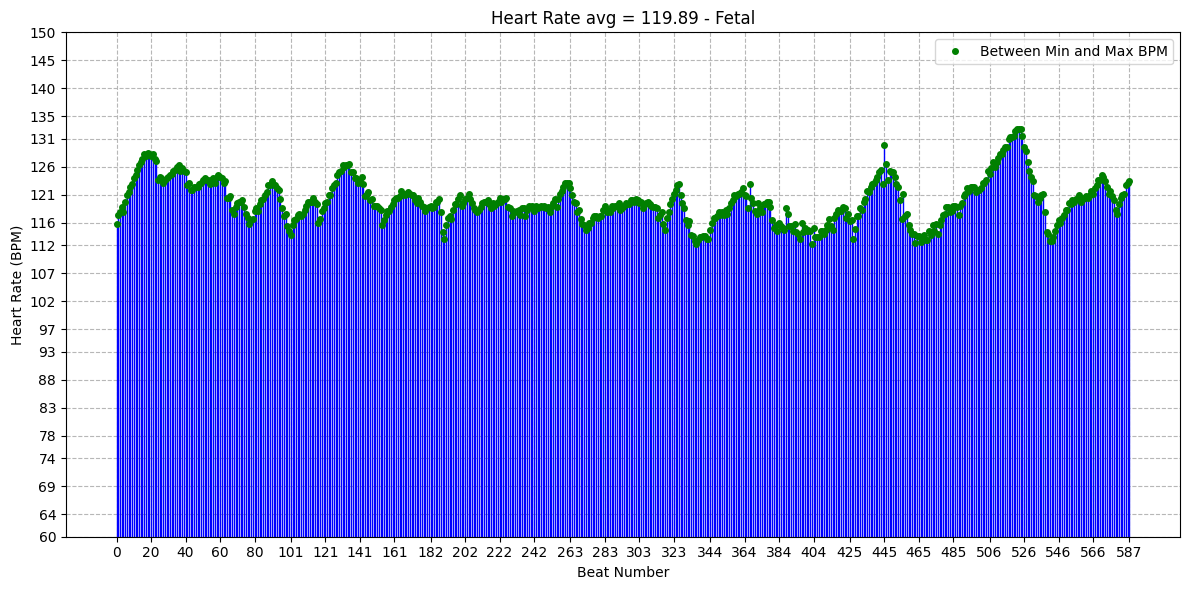

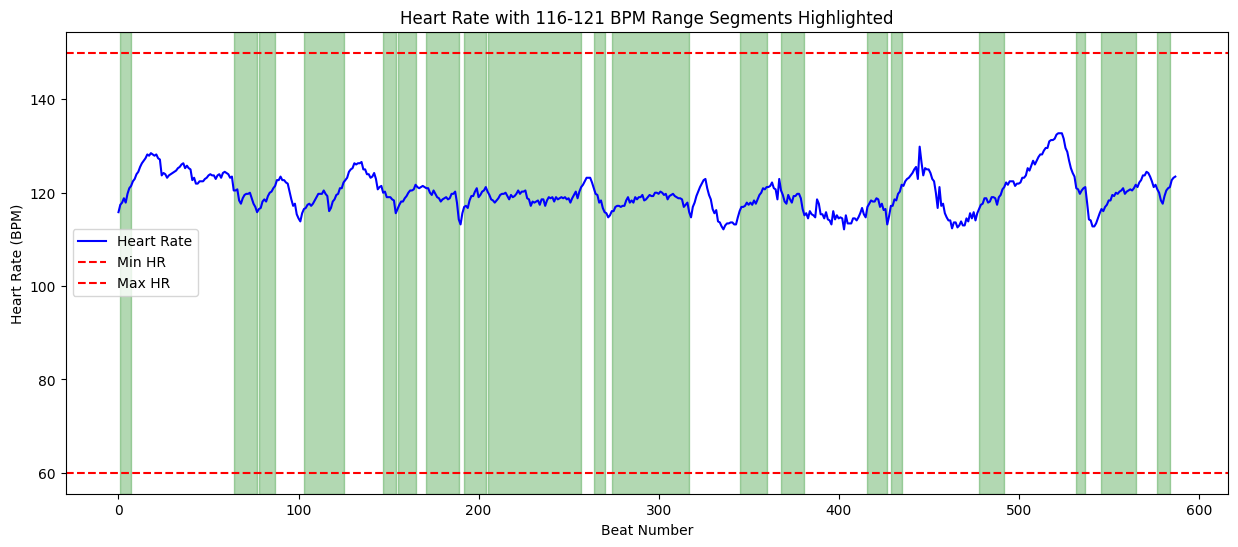

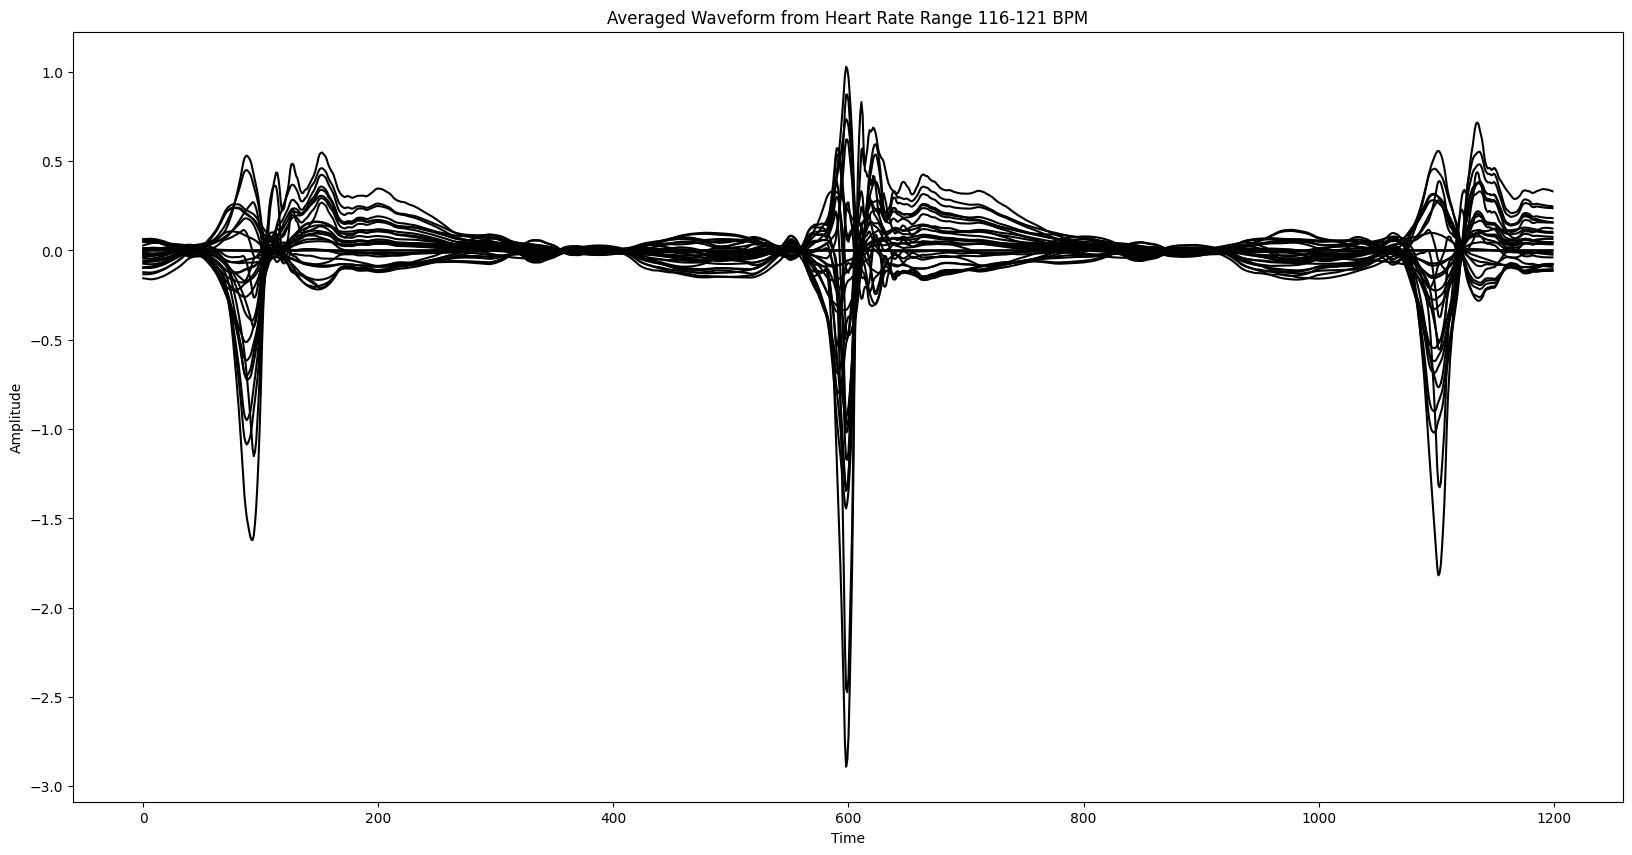

In [104]:

fetal = sources[:, compF]
heartRate, peaksMat = functions.plotHR(fetal)
range_segments = functions.identify_hr_range_segments(heartRate, min_hr=116, max_hr=121, plot=True, min_segment_length=5)
avg_waveform = functions.avg_channels_hr_range(remaining_fetal, peaksMat, heartRate, window_size=1200, denoise=True, plot=True, min_hr=116, max_hr=121)